# Project 01: one protein against many ligands 

The purpose is to find interaction hotspots in a single target through the analysis of interactions found in a dataset of diverse small compounds.

This was used in the prototype pipeline to elucidate hotspots in the sars-cov-19 protease, and we will refine it here against other datasets.

The workflow itself consists of three steps:

1. Obtaining and sanitizing the data
2. Ingesting it in `plipify`
3. Generating publication-worthy figures

In [1]:
!mkdir -p data output

## Obtaining and sanitizing the data

We will be using data from [_Fragalysis_](), a XRC platform that generates structures for ligand collections against a given target. API endpoint is described [here](https://fragalysis.diamond.ac.uk/api/?format=api), but in short, it seems that you can download a full featured zip file using this URL: `https://fragalysis.diamond.ac.uk/media/targets/$TARGETNAME.zip`.

In [2]:
TARGET = "Mpro"

In [3]:
import requests

r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json&title={TARGET}")
r.raise_for_status()
target = r.json()["results"][0]
print(target)

{'id': 68, 'title': 'Mpro', 'project_id': [2], 'protein_set': [37176, 36464, 37186, 37200, 37210, 37136, 37150, 37164, 37272, 37324, 37346, 37266, 37222, 37238, 37267, 37207, 37311, 37309, 37131, 37274, 37243, 37187, 37148, 37337, 37116, 37276, 36456, 36465, 36365, 36366, 36367, 36368, 36369, 36370, 36364, 36371, 36372, 36373, 36386, 36375, 36387, 36376, 36377, 36388, 36378, 36379, 36380, 36381, 36382, 36383, 36384, 36385, 36374, 36389, 36392, 36411, 36395, 36391, 36394, 36399, 36393, 36398, 36397, 36396, 36402, 36404, 36401, 36429, 36400, 36403, 36405, 36406, 36413, 36407, 36408, 36409, 36421, 36410, 36415, 36417, 36412, 36414, 36419, 36416, 36420, 36426, 36418, 36422, 36423, 36424, 36425, 36427, 36428, 36430, 36432, 36434, 36436, 36433, 36438, 36435, 36437, 36440, 36439, 36390, 36431, 36443, 36444, 36445, 36446, 36442, 36449, 36455, 36450, 36453, 36451, 36458, 36459, 36452, 36454, 36457, 36460, 36461, 36462, 36463, 36448, 36466, 36467, 37074, 36441, 36447, 37107, 37093, 37081, 37102,

In [22]:
from pathlib import Path
if not Path(f"data/{TARGET}.zip").is_file():
    !curl -L "{target['zip_archive']}" -o data/{TARGET}.zip
    !unzip -qqo data/{TARGET}.zip -d data/

In [20]:
!ls data/

Mpro.zip			  Mpro_soaks.csv       crystallographic
Mpro_cocrystallisation.csv	  aligned	       hits_ids.csv
Mpro_compound_tracker_csv.csv	  alternate_names.csv  metadata.csv
Mpro_compound_tracker_excel.xlsx  biomol.txt	       sites.csv


For completeness, we'll also query the `target` API endpoint to see what we could be missing:

Most of the contextual information can be found in `metadata.csv`, which we can load with `pandas`:

In [21]:
import pandas as pd
metadata = pd.read_csv("data/metadata.csv", index_col=0)
metadata

,crystal_name,RealCrystalName,smiles,new_smiles,alternate_name,site_name,pdb_entry
1,Mpro-6lze_0A,Mpro-6lze,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](CC1CCCCC1...,NaN,NaN,P1 - PDB structures,6LZE
2,Mpro-6m0k_0A,Mpro-6m0k,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](Cc1cccc(F...,NaN,NaN,P1 - PDB structures,6M0K
3,Mpro-6m2n_0A,Mpro-6m2n,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,NaN,NaN,P1 - PDB structures,6M2N
4,Mpro-6m2n_0B,Mpro-6m2n,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,NaN,NaN,P1 - PDB structures,6M2N
5,Mpro-6m2n_0C,Mpro-6m2n,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,NaN,NaN,P1 - PDB structures,6M2N
...,...,...,...,...,...,...,...
407,Mpro-x3348_0A,Mpro-x3348,CC(=O)N1CCN(CC1)C(C1=CC=CC=C1)C1=CC=CC=C1,CC(=O)N1CCN(CC1)C(C1=CC=CC=C1)C1=CC=CC=C1,SIM-SYN-f15aaa3a-1,A3 - Chloroacetamide,NaN
408,Mpro-x3351_0A,Mpro-x3351,CNCC1=CNC=2C=CC(F)=CC12,NaN,DAR-DIA-eace69ff-36,M1 - Moonshot - other,NaN
409,Mpro-x3351_1A,Mpro-x3351,CNCC1=CNC=2C=CC(F)=CC12,NaN,DAR-DIA-eace69ff-36,M1 - Moonshot - other,NaN
410,Mpro-x3359_0A,Mpro-x3359,CCNC(=O)C(N(C(=O)CC)C1=CC=C(C=C1)C(C)(C)C)C1=C...,CCNC(=O)C(N(C(=O)CC)C1=CC=C(C=C1)C(C)(C)C)C1=C...,LON-WEI-adc59df6-30,A6 - Ugi,5RL5


With some RDKit magic, we can get the smiles represented in 2D:

,crystal_name,RealCrystalName,smiles,new_smiles,alternate_name,site_name,pdb_entry,ROMol
1,Mpro-6lze_0A,Mpro-6lze,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](CC1CCCCC1...,NaN,NaN,P1 - PDB structures,6LZE,
2,Mpro-6m0k_0A,Mpro-6m0k,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](Cc1cccc(F...,NaN,NaN,P1 - PDB structures,6M0K,
3,Mpro-6m2n_0A,Mpro-6m2n,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,NaN,NaN,P1 - PDB structures,6M2N,
4,Mpro-6m2n_0B,Mpro-6m2n,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,NaN,NaN,P1 - PDB structures,6M2N,
5,Mpro-6m2n_0C,Mpro-6m2n,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,NaN,NaN,P1 - PDB structures,6M2N,
...,...,...,...,...,...,...,...,...
407,Mpro-x3348_0A,Mpro-x3348,CC(=O)N1CCN(CC1)C(C1=CC=CC=C1)C1=CC=CC=C1,CC(=O)N1CCN(CC1)C(C1=CC=CC=C1)C1=CC=CC=C1,SIM-SYN-f15aaa3a-1,A3 - Chloroacetamide,NaN,
408,Mpro-x3351_0A,Mpro-x3351,CNCC1=CNC=2C=CC(F)=CC12,NaN,DAR-DIA-eace69ff-36,M1 - Moonshot - other,NaN,
409,Mpro-x3351_1A,Mpro-x3351,CNCC1=CNC=2C=CC(F)=CC12,NaN,DAR-DIA-eace69ff-36,M1 - Moonshot - other,NaN,
410,Mpro-x3359_0A,Mpro-x3359,CCNC(=O)C(N(C(=O)CC)C1=CC=C(C=C1)C(C)(C)C)C1=C...,CCNC(=O)C(N(C(=O)CC)C1=CC=C(C=C1)C(C)(C)C)C1=C...,LON-WEI-adc59df6-30,A6 - Ugi,5RL5,

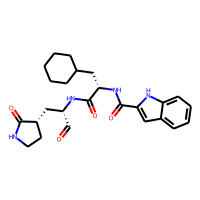
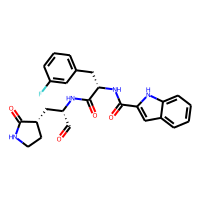
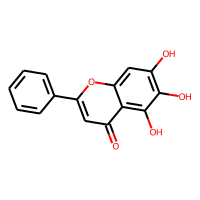
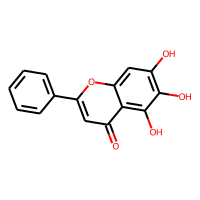
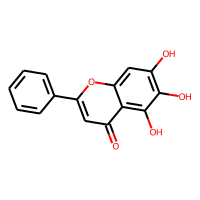
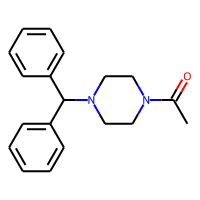
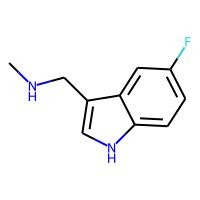
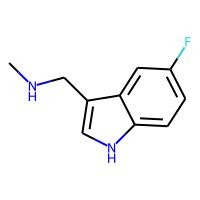
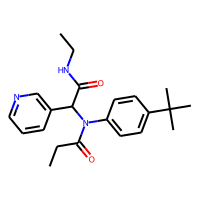
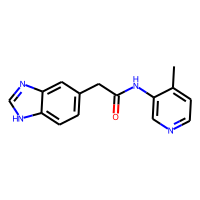

In [8]:
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
AddMoleculeColumnToFrame(metadata, smilesCol="smiles")
metadata

Prealigned PDBs for each row can be found in `data/aligned/{crystal_name}/{crystal_name}_bound.pdb`:

In [9]:
import nglview as nv

view = nv.show_structure_file(f"data/aligned/{metadata.crystal_name[1]}/{metadata.crystal_name[1]}_bound.pdb")
view

NGLWidget()

As the directory name suggests, these are prealigned:

In [10]:
from time import sleep
view = nv.NGLWidget()
for i in range(1, 5):
    structure = nv.adaptor.FileStructure(f"data/aligned/{metadata.crystal_name[i]}/{metadata.crystal_name[i]}_bound.pdb")
    view.add_component(structure)
view

NGLWidget()

Notice how binding sites are not always the same.

What the zip archive does not include is information about the interactions, but this is indeed available in the API! Getting that information requires several steps, though:

In [11]:
def interactions_for_structure(target_id):
    """
    1. Get all compounds associated with target
    2. Interactions can be queried by pairs of protein residue and compound
    3. 
    """
    r = requests.get(f"https://fragalysis.diamond.ac.uk/api/molgroup/?target_id={target_id}&group_type=MC")
    r.raise_for_status()
    molgroups = r.json()
    ligands = []
    for molgroup in molgroups["results"]:
        r = requests.get(f"https://fragalysis.diamond.ac.uk/api/molecules/?mol_groups={molgroup['id']}&mol_type=PR")
        r.raise_for_status()
        ligands.extend(r.json()["results"])
        
    interaction_points = []
#     # TODO
#     for ligand in ligands:
#         url = f"https://fragalysis.diamond.ac.uk/api/interactionpoints/?mol_id={ligand['cmpd_id']}"
#         while url:
#             r = requests.get(url)
#             r.raise_for_status()
#             data = r.json()
#             interaction_points.extend(data["results"])
#             url = data["next"]
        
                        
    return ligands, interaction_points

In [12]:
ligands, interactions = interactions_for_structure(68)

In [13]:
ligands[0]

{'id': 37159,
 'smiles': 'CC(=O)Nc1cnccc1C',
 'cmpd_id': 3830,
 'prot_id': 37070,
 'protein_code': 'Mpro-x0107A:MAK-UNK-6435e6c2-8',
 'mol_type': 'PR',
 'molecule_protein': '/media/pdbs/Mpro-x0107_0A_apo.pdb',
 'lig_id': 'LIG',
 'chain_id': 'Z',
 'sdf_info': '\n     RDKit          3D\n\n 11 11  0  0  0  0  0  0  0  0999 V2000\n   10.0930   -0.7090   22.5610 C   0  0  0  0  0  0  0  0  0  0  0  0\n    9.1970   -0.0850   21.4940 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.0950   -0.1380   20.0970 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.4670   -0.2020   18.7610 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.5850    0.9230   18.1010 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.1320    1.0430   19.4080 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.9020    0.4960   20.4350 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.4610    0.5980   21.8930 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.9490   -0.7270   21.1170 N   0  0  0  0  0  0  0  0  0  0  0  0\n    6.7150    0.3200   17.8100 N

In [14]:
len(ligands)

391

## Ingesting it in `plipify` 

TBD.

In [15]:
from plipify.plip_fingerprints import read_residues
from plipify.core import Structure
from plipify.fingerprints import InteractionFingerprint
from tqdm.auto import tqdm
from pathlib import Path

In [25]:
indices = list(range(20, 193))

def calculate_fingerprints(structure_folder, ligand_identifier="LIG"):
    structures = [Structure.from_pdbfile(str(path), ligand_identifier=ligand_identifier)
                  for path in tqdm(Path(structure_folder).glob("**/*_bound.pdb"))]
   
    return InteractionFingerprint(indices).calculate_fingerprint(
        structures,
        labeled=True, 
        as_dataframe=True, 
        remove_non_interacting_residues=True
    )

In [26]:
fp = calculate_fingerprints("data/aligned/")
fp


! Warning, could not process structure <plipify.core.Structure object at 0x7f294dec38e0> due to error ValueError No residue with such sequence index: 20, None!
! Warning, could not process structure <plipify.core.Structure object at 0x7f294d7177c0> due to error ValueError No residue with such sequence index: 20, None!
! Warning, could not process structure <plipify.core.Structure object at 0x7f294d7f7940> due to error ValueError No residue with such sequence index: 46, None!
! Warning, could not process structure <plipify.core.Structure object at 0x7f294dcb3130> due to error ValueError No residue with such sequence index: 20, None!
! Warning, could not process structure <plipify.core.Structure object at 0x7f294d6a6dc0> due to error ValueError No residue with such sequence index: 145, None!
! Warning, could not process structure <plipify.core.Structure object at 0x7f294db48850> due to error ValueError No residue with such sequence index: 20, None!
! Warning, could not process structure

AssertionError: 

## Generating publication-worthy figures

TBD.